In [ ]:
# TODO: pin transformers version
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 29.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_excel('/content/drive/MyDrive/Adobe/content_simulation_train.xlsx')

In [ ]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16506 sha256=619167d1818c57e3f3dc91566cd905c5930c8c59fbc1c99542a5a4724a8e231a
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [ ]:
def extract_link(x):
    match_ = re.search(r"previewUrl='(.*?)'|thumbnailUrl='(.*?)'", x)
    if match_:
        return match_.group(1) or match_.group(2)
    else:
        return "URL not found."

In [ ]:
import swifter
import re
df['extracted_links'] = df['media'].swifter.apply(extract_link)

Pandas Apply:   0%|          | 0/300000 [00:00<?, ?it/s]

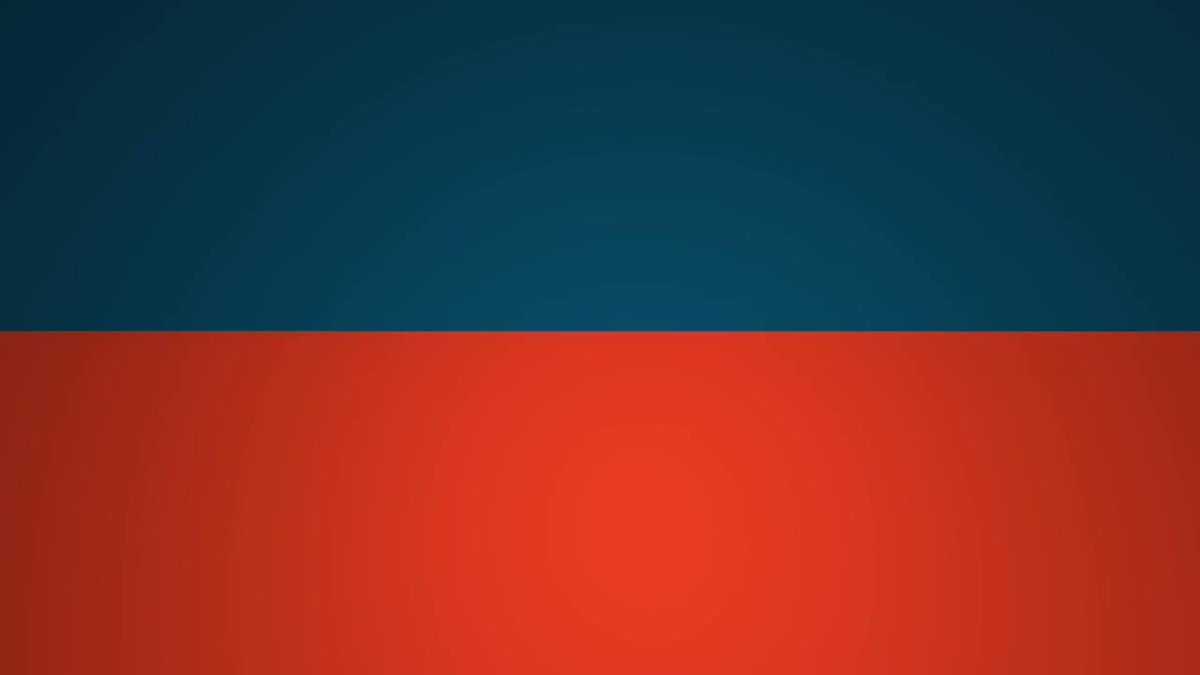

In [ ]:
import requests
from PIL import Image
import pandas as pd

# Assuming df is your DataFrame containing the 'image' column
# Fetching the first row's 'image' value
first_image_url = df['extracted_links'].iloc[1050]



image_url = first_image_url
image = Image.open(requests.get(image_url, stream=True).raw)
image

In [ ]:
import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

## Load the model using `pipeline`

We will leverage the `image-to-text` pipeline from transformers !

In [ ]:
from transformers import pipeline

model_id = "llava-hf/llava-1.5-7b-hf"

pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

config.json:   0%|          | 0.00/954 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

In [ ]:
import re
examples = [
    ["image: df['extracted_links].iloc[0]", "Date: 2020-12-12 00:47:00, brand_name: tim hortons, username: TimHortonsPH, likes: 1", "outputs: Spend your weekend morning with a Ham, Egg, and Cheese Wrap paired with a sweet Iced French Vanilla! ☀️ Order yours now via dine-in, takeout, and delivery. #TimHortonsPH <hyperlink>"],
    ["image: df['extracted_links].iloc[13]", "Date: 2018-08-17 13:00:18, brand_name: pfizer, username: Pfizer_UK, likes: 2","outputs:#DYK whilst #TickBorneEncephalitis is not found in the UK, it can occur in many popular holiday destinations in Europe. Find out more: <hyperlink> #TickAlert #TravelBug <hyperlink>"]]
prompt_examples = "\n".join([f"{example}" for example in examples])
arr = []
def tweet(link, brand, username, likes,date,arr):
    first_image_url = link

    try:
        # Attempt to load the image from the URL
        image = Image.open(requests.get(first_image_url, stream=True).raw)
    except Exception as e:
        print(f"Error loading image from {first_image_url}: {e}")
        return "Image not loaded"

    brand_name = brand
    username = username
    likes = likes
    date = date
    prompt2 = f"USER: <image>\nCreate an engaging tweet caption for this image that aligns with {brand_name} style. Do consider the other name {username} . the date of the tweet is {date} , see if there is anything special on this day. Identify the place and text in the image. Also identify the objects in the image. Craft it to gather {likes} likes. Avoid direct brand mentions or like counts in the output. Incorporate relevant hashtags for maximum engagement."
    prompt = f"USER: <image>\nGenerate a tweet caption for this specific image that has brand name = {brand_name}, make a marketing tweet text in a way that it receives {likes} likes.the date of the tweet is {date}. Do not print the brand name and likes, and also provide hashtags."


    outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
    text = outputs[0]['generated_text']
    original_string = text
    sentence_to_remove = "USER:this is the input image:  \nCreate a compelling tweet caption for the image featuring the brand \'pepsico\' and has twitter username \'PepsiCoAMESA\'. identify the text in the image and Craft a tweet such a way to get \'1\' likes. Avoid mentioning the likes explicitly. Include relevant hashtags to enhance visibility and appeal. Be creative and engaging in your description. Also try identifying the place in the image and also the objects present in the image. mention the place in the image. Do mention the username . Give one liner text only. \n\n"
    result_string = original_string.replace(sentence_to_remove, "")
    print(result_string)
    arr.append(result_string)
    arr_1 = pd.DataFrame(arr)
    file_path = 't291.csv'
    arr_1.to_csv(file_path, index=False, encoding='utf-8')
    return arr




def build(df):
    length = len(df)
    df_re = pd.read_csv('/content/t291.csv',encoding='utf-8')
    #arr_1.to_csv(file_path, index=False, encoding='utf-8')
    arr = df_re.iloc[:,0].tolist()
    for i in range(length):
        arr = tweet(df['extracted_links'].iloc[i],df['inferred company'].iloc[i],df['username'].iloc[i],df['likes'].iloc[i],df['date'].iloc[i],arr)
        print(i)

build(df.iloc[0:10])

USER:  
Generate a tweet caption for this specific image that has brand name = tim hortons, make a marketing tweet text in a way that it receives 1 likes.the date of the tweet is 2020-12-12 00:47:00. Do not print the brand name and likes, and also provide hashtags.

"Satisfy your morning cravings with a delicious sandwich and a refreshing drink from Tim Hortons! 🍔🥤 #morningmotivation #timhortons"
0
USER:  
Generate a tweet caption for this specific image that has brand name = independent, make a marketing tweet text in a way that it receives 2750 likes.the date of the tweet is 2018-06-30 10:04:20. Do not print the brand name and likes, and also provide hashtags.

"Independent musician on stage, with a microphone in hand, ready to rock the crowd. #music #stage #microphone #independent"
1
USER:  
Generate a tweet caption for this specific image that has brand name = cbc, make a marketing tweet text in a way that it receives 57 likes.the date of the tweet is 2020-09-29 19:47:28. Do not pr

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


USER:  
Generate a tweet caption for this specific image that has brand name = cisco, make a marketing tweet text in a way that it receives 3 likes.the date of the tweet is 2018-07-17 22:04:26. Do not print the brand name and likes, and also provide hashtags.

"Cisco's new product is out! Get ready to be amazed by its features. #CiscoInnovations #NewTechnology #StayConnected"
7
USER:  
Generate a tweet caption for this specific image that has brand name = cnn, make a marketing tweet text in a way that it receives 572 likes.the date of the tweet is 2019-03-27 12:18:01. Do not print the brand name and likes, and also provide hashtags.

"Police officers are seen shaking hands with a man in a suit. This moment captured by CNN shows the importance of peaceful resolutions. #peace #resolution #police #suit"
8
USER:  
Generate a tweet caption for this specific image that has brand name = getty images, make a marketing tweet text in a way that it receives 127 likes.the date of the tweet is 2020

In [ ]:
Gen_data_csv= pd.read_csv('/content/t291.csv')

In [ ]:
Gen_data_csv.tail(2)

,0
11,USER: \nGenerate a tweet caption for this spe...
12,USER: \nGenerate a tweet caption for this spe...


In [ ]:
str(Gen_data_csv.iloc[0,0])

'USER:  \nGenerate a tweet caption for this specific image that has brand name = tim hortons, make a marketing tweet text in a way that it receives 1 likes.the date of the tweet is 2020-12-12 00:47:00. Do not print the brand name and likes, and also provide hashtags.\n\n"Satisfy your morning cravings with a delicious sandwich and a refreshing drink from Tim Hortons! 🍔🥤 #morningmotivation #timhortons"'

In [ ]:
match_txt = re.search(r'"([^"]*)"', str(Gen_data_csv.iloc[0,0]))
print(match_txt)

<re.Match object; span=(267, 399), match='"Satisfy your morning cravings with a delicious s>


In [ ]:
if match_txt:
    extracted_text = match_txt.group(1)
    print(extracted_text)
else:
    print("No text within double quotes found.")

Satisfy your morning cravings with a delicious sandwich and a refreshing drink from Tim Hortons! 🍔🥤 #morningmotivation #timhortons


In [ ]:
import re
#import wikitextparser as wtp

In [ ]:
def extract_text(input_string):
    match_txt = re.search(r'"([^"]*)"', str(input_string))

    if match_txt:
        extracted_text = match_txt.group(1)
        extracted_text_with_hyperlink = re.sub(r'#(\w+)', r'#\1 <hyperlink>', extracted_text)

        return extracted_text_with_hyperlink
    else:
        return "No text within double quotes found."

In [ ]:
len(Gen_data_csv)

13

In [ ]:
for i in range(len(Gen_data_csv)):
  Gen_data_csv_value = str(Gen_data_csv.iloc[3,0])

result = extract_text(Gen_data_csv_value)

In [ ]:
Gen_data_csv_value = str(Gen_data_csv.iloc[3,0])

result = extract_text(Gen_data_csv_value)

In [ ]:
result

'Satisfy your morning cravings with a delicious sandwich and a refreshing drink from Tim Hortons! 🍔🥤 #morningmotivation <hyperlink> #timhortons <hyperlink>'

In [ ]:
# Assuming `Gen_data_csv` is your DataFrame
data_df = pd.DataFrame(columns=["Index", "Processed_Text"])

for i in range(len(Gen_data_csv)):
    Gen_data_csv_value = str(Gen_data_csv.iloc[i, 0])
    processed_text = extract_text(Gen_data_csv_value)

    # Append data to the DataFrame
    data_df = data_df.append({
        "Index": i,
        "Processed_Text": processed_text
    }, ignore_index=True)

# Save the DataFrame to a CSV file
data_df.to_excel("content_simulation_test_time_Results.xlsx", index=False)